# Autoencoder Sequence-to-Sequence Model for Speech

Herman Kamper, Stellenbosch University, 2018.

## Preamble

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function
from os import path
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf

In [2]:
sys.path.append(path.join("..", "src"))

import plotting
import samediff
import tflego
import training

from tflego import NP_DTYPE, TF_DTYPE, NP_ITYPE, TF_ITYPE

output_dir = "/tmp/data-kamperh/"

## Utility functions and classes

In [3]:
class SimpleIterator(object):
    
    def __init__(self, x_list, batch_size, shuffle_every_epoch=False):
        self.x_list = x_list
        self.batch_size = batch_size
        self.shuffle_every_epoch = shuffle_every_epoch
        self.n_input = self.x_list[0].shape[-1]
        self.x_lengths = np.array([i.shape[0] for i in x_list])
        self.n_batches = int(len(self.x_lengths)/batch_size)
        self.indices = np.arange(len(self.x_lengths))
        np.random.shuffle(self.indices)
    
    def __iter__(self):

        if self.shuffle_every_epoch:
            np.random.shuffle(self.indices)
        
        for i_batch in xrange(self.n_batches):

            batch_indices = self.indices[
                i_batch*self.batch_size:(i_batch + 1)*self.batch_size
                ]
            
            batch_x_lengths = self.x_lengths[batch_indices]

            # Pad to maximum length in batch
            batch_x_padded = np.zeros(
                (len(batch_indices), np.max(batch_x_lengths), self.n_input),
                 dtype=NP_DTYPE
                )
            for i, length in enumerate(batch_x_lengths):
                seq = self.x_list[batch_indices[i]]
                batch_x_padded[i, :length, :] = seq

            yield (batch_x_padded, batch_x_lengths)

In [4]:
class SimpleBucketIterator(object):
    
    def __init__(self, x_list, batch_size, n_buckets, shuffle_every_epoch=False):
        self.x_list = x_list
        self.batch_size = batch_size
        self.shuffle_every_epoch = shuffle_every_epoch
        self.n_input = self.x_list[0].shape[-1]
        self.x_lengths = np.array([i.shape[0] for i in x_list])
        self.n_batches = int(len(self.x_lengths)/batch_size)
        
        # Set up bucketing
        self.n_buckets = n_buckets
        sorted_indices = np.argsort([len(i) for i in x_list])
        bucket_size = int(len(self.x_lengths)/self.n_buckets)
        self.buckets = []
        for i_bucket in xrange(n_buckets):
            self.buckets.append(
                sorted_indices[i_bucket*bucket_size:(i_bucket + 1)*bucket_size]
                )
        self.shuffle()
            
    def shuffle(self):
        for i_bucket in xrange(self.n_buckets):
            np.random.shuffle(self.buckets[i_bucket])
        self.indices = np.concatenate(self.buckets)
    
    def __iter__(self):

        if self.shuffle_every_epoch:
            self.shuffle()
        
        for i_batch in xrange(self.n_batches):

            batch_indices = self.indices[
                i_batch*self.batch_size:(i_batch + 1)*self.batch_size
                ]
            
            batch_x_lengths = self.x_lengths[batch_indices]

            # Pad to maximum length in batch
            batch_x_padded = np.zeros(
                (len(batch_indices), np.max(batch_x_lengths), self.n_input),
                 dtype=NP_DTYPE
                )
            for i, length in enumerate(batch_x_lengths):
                seq = self.x_list[batch_indices[i]]
                batch_x_padded[i, :length, :] = seq

            yield (batch_x_padded, batch_x_lengths)

## Data

In [5]:
# Training data

# NumPy archive
npz = np.load(
    path.join("..", "features", "wordpairs", "devpart1",
    "devpart1.samediff.mfcc.cmvn_dd.npz")
    )

# Data and labels
train_x = []
train_labels = []
train_lengths = []
train_keys = []
n_items = 0
for utt_key in sorted(npz):
    train_keys.append(utt_key)
    train_x.append(npz[utt_key])
    word = "_".join(utt_key.split("_")[:-2])
    train_labels.append(word)
    train_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", train_x[0].shape)

No. items: 5106
E.g. item shape: (51, 39)


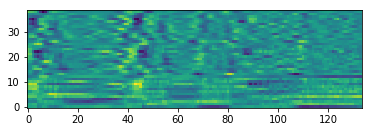

In [6]:
plt.imshow(train_x[3277].T, origin="bottom");

In [58]:
# Development data

# NumPy archive
npz = np.load(
    path.join("..", "features", "wordpairs", "devpart2",
    "devpart2.samediff.mfcc.cmvn_dd.npz")
    )

# Data and labels
val_x = []
val_labels = []
val_lengths = []
val_keys = []
n_items = 0
for utt_key in sorted(npz):
    val_keys.append(utt_key)
    val_x.append(npz[utt_key])
    word = "_".join(utt_key.split("_")[:-2])
    val_labels.append(word)
    val_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", val_x[0].shape)

No. items: 2733
E.g. item shape: (61, 39)


In [59]:
# Truncate and limit dimensionality
max_length = 100
d_frame = 13  # None
for i, seq in enumerate(train_x):
    train_x[i] = train_x[i][:max_length, :d_frame]
    train_lengths[i] = min(train_lengths[i], max_length)
for i, seq in enumerate(val_x):
    val_x[i] = val_x[i][:max_length, :d_frame]
    val_lengths[i] = min(val_lengths[i], max_length)

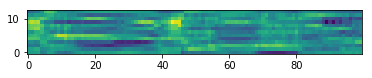

In [60]:
plt.imshow(train_x[3277].T, origin="bottom");

In [61]:
# Scale training and validation to between 0 and 1
train_x_scaled = []
val_x_scaled = []
for seq in train_x:
    cur_seq = np.clip(
        (seq - train_x_min)/(train_x_max - train_x_min),
        train_x_min, train_x_max
        )
    train_x_scaled.append(cur_seq)
for seq in val_x:
    cur_seq = np.clip(
        (seq - train_x_min)/(train_x_max - train_x_min),
        train_x_min, train_x_max
        )
    val_x_scaled.append(cur_seq)

# # First scale mean and variance
# train_frames = []
# for seq in train_x:
#     for frame in seq:
#         train_frames.append(frame)
# train_frames = np.array(train_frames)
# mean = train_frames.mean(axis=0)
# std = train_frames.std(axis=0)
# train_x_scaled = []
# val_x_scaled = []
# train_x_min = np.inf
# train_x_max = -np.inf
# for seq in train_x:
#     cur_seq = (seq - mean)/std
#     train_x_scaled.append(cur_seq)
#     train_x_min = np.min(cur_seq) if np.min(cur_seq) < train_x_min else train_x_min
#     train_x_max = np.max(cur_seq) if np.max(cur_seq) > train_x_max else train_x_max
# for seq in val_x:
#     val_x_scaled.append((seq - mean)/std)

# # Scale training and validation to between 0 and 1
# for i, seq in enumerate(train_x_scaled):
#     cur_seq = np.clip(
#         (seq - train_x_min)/(train_x_max - train_x_min),
#         train_x_min, train_x_max
#         )
#     train_x_scaled[i] = cur_seq
# for i, seq in enumerate(val_x_scaled):
#     cur_seq = np.clip(
#         (seq - train_x_min)/(train_x_max - train_x_min),
#         train_x_min, train_x_max
#         )
#     val_x_scaled[i] = cur_seq

0.19249712018 0.786640710401


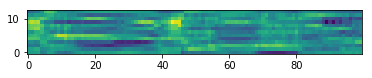

In [62]:
plt.imshow(train_x_scaled[3277].T, origin="bottom");
print(np.min(train_x_scaled[3277]), np.max(train_x_scaled[3277]))

## Autoencoder with direct decoding

Here the final state of the encoder is passed on directly to the decoder (without any intermediate transformation).

In [63]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 50  # 50
batch_size = 100
n_buckets = 3

# Model parameters
n_input = d_frame
n_hidden = 150
rnn_type = "gru"  # "lstm", "gru" or "rnn"
model_fn = path.join(output_dir, "lazydynamic_ae.ckpt")

# Model
x = tf.placeholder(TF_DTYPE, [None, None, n_input])
x_lengths = tf.placeholder(TF_ITYPE, [None])
network_dict = tflego.build_encdec_lazydynamic(
    x, x_lengths, n_hidden, rnn_type=rnn_type
    )
encoder_states = network_dict["encoder_states"]
y = network_dict["decoder_output"]
mask = network_dict["mask"]

y *= tf.expand_dims(mask, -1)  # safety

# Reconstruction loss
loss = tf.reduce_mean(
    tf.reduce_sum(tf.reduce_mean(tf.square(x - y), -1), -1) /
    tf.reduce_sum(mask, 1)
    )  # https://danijar.com/variable-sequence-lengths-in-tensorflow/

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [11]:
np.random.seed(1)
train_batch_iterator = SimpleBucketIterator(
    train_x, batch_size, n_buckets, True
    )
val_batch_iterator = SimpleBucketIterator(
    val_x, batch_size, n_buckets, False
    )

record_dict = training.train_fixed_epochs(
    n_epochs, optimizer, loss, train_batch_iterator,
    [x, x_lengths], loss, val_batch_iterator, save_best_val_model_fn=model_fn
    )

2018-06-11 11:58:42.172534
Epoch 0:
3.510 sec, train loss: 0.926742, val loss: 0.775968 *
Epoch 1:
3.359 sec, train loss: 0.727186, val loss: 0.687394 *
Epoch 2:
3.364 sec, train loss: 0.648977, val loss: 0.654442 *
Epoch 3:
3.383 sec, train loss: 0.635469, val loss: 0.626996 *
Epoch 4:
3.358 sec, train loss: 0.586699, val loss: 0.602716 *
Epoch 5:
3.365 sec, train loss: 0.549258, val loss: 0.55305 *
Epoch 6:
3.366 sec, train loss: 0.519703, val loss: 0.546202 *
Epoch 7:
3.387 sec, train loss: 0.487933, val loss: 0.508338 *
Epoch 8:
3.372 sec, train loss: 0.483006, val loss: 0.52048
Epoch 9:
3.369 sec, train loss: 0.466497, val loss: 0.518474
Epoch 10:
3.360 sec, train loss: 0.454116, val loss: 0.488978 *
Epoch 11:
3.370 sec, train loss: 0.425874, val loss: 0.466728 *
Epoch 12:
3.363 sec, train loss: 0.436099, val loss: 0.484989
Epoch 13:
3.363 sec, train loss: 0.434821, val loss: 0.46735
Epoch 14:
3.373 sec, train loss: 0.410614, val loss: 0.474381
Epoch 15:
3.364 sec, train loss: 0.3

In [12]:
# Embed validation
val_batch_iterator = SimpleIterator(
    val_x, len(val_x), False
    )
labels = [val_labels[i] for i in val_batch_iterator.indices]
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    for batch_x_padded, batch_x_lengths in val_batch_iterator:
        np_x = batch_x_padded
        np_x_lengths = batch_x_lengths
        np_z = session.run(
            [encoder_states], feed_dict={x: np_x, x_lengths: np_x_lengths}
            )[0]
        np_y = session.run(
            [y], feed_dict={x: np_x, x_lengths: np_x_lengths}
            )[0]
        break  # single batch

embed_dict = {}
for i, utt_key in enumerate([val_keys[i] for i in val_batch_iterator.indices]):
    embed_dict[utt_key] = np_z[i]

INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/lazydynamic_ae.ckpt


In [13]:
# Same-different evaluation
distances = pdist(np_z, metric="cosine")
matches = samediff.generate_matches_array(labels)
ap, prb = samediff.average_precision(
    distances[matches == True], distances[matches == False]
    )

print("Average precision: {:.4f}".format(ap))
print("Precision-recall breakeven: {:.4f}".format(prb))

Average precision: 0.1802
Precision-recall breakeven: 0.2276


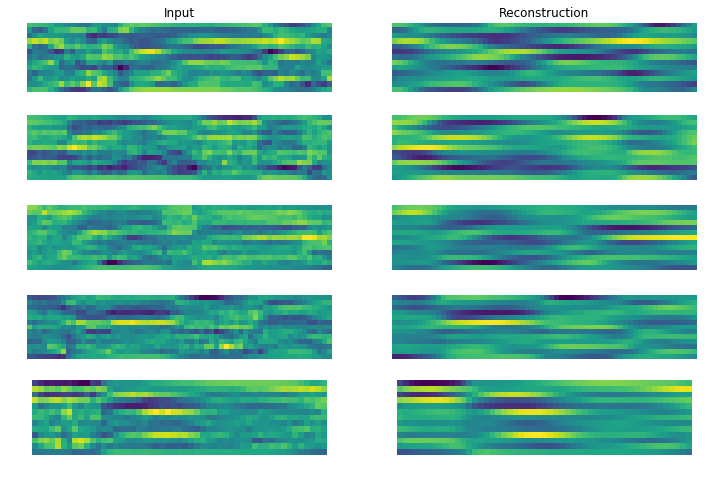

In [14]:
# Plot reconstruction
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    if i == 0:
        plt.title("Input")
    plt.imshow(np_x[i][:np_x_lengths[i]].T)
    plt.axis("off")
    plt.subplot(5, 2, 2*i + 2)
    if i == 0:
        plt.title("Reconstruction")
    plt.imshow(np_y[i][:np_x_lengths[i]].T)
    plt.axis("off")

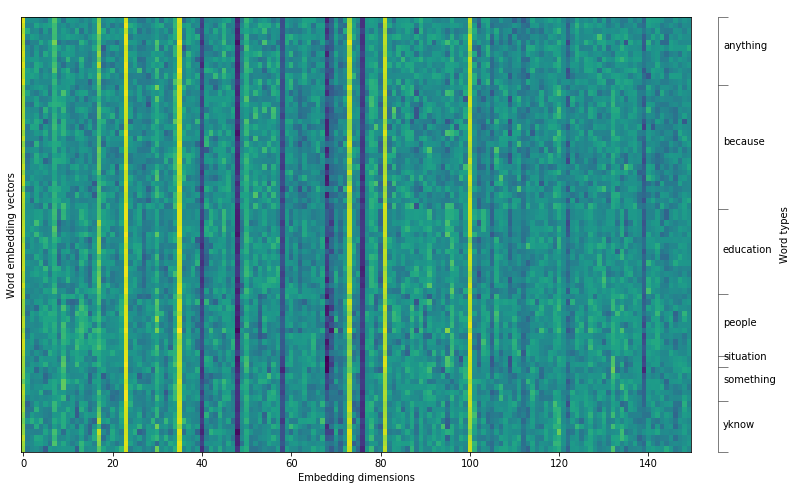

In [22]:
plotting.plot_raw_embeds(
    embed_dict, ["because", "yknow", "people", "something", "anything", "education", "situation"],
    figsize=(12, 8)
    )

## Autoencoder with latent transformation

After the encoder, a transformation is performed to obtain the latent representation, before conditioning the decoder.

In [81]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 200  # 50
batch_size = 100
n_buckets = 3

# Model parameters
n_input = d_frame
n_hidden = 150
build_latent_func = tflego.build_autoencoder
latent_func_kwargs = {
    "enc_n_hiddens": [],
    "n_z": 130,
    "dec_n_hiddens": [n_hidden],
    "activation": tf.nn.relu
    }
rnn_type = "gru"  # "lstm", "gru" or "rnn"
model_fn = path.join(output_dir, "lazydynamic_latent_ae.ckpt")

# Model
x = tf.placeholder(TF_DTYPE, [None, None, n_input])
x_lengths = tf.placeholder(TF_ITYPE, [None])
network_dict = tflego.build_encdec_lazydynamic_latentfunc(
    x, x_lengths, n_hidden, build_latent_func,
    latent_func_kwargs, rnn_type=rnn_type
    )
encoder_states = network_dict["encoder_states"]
y = network_dict["decoder_output"]
ae = network_dict["latent_layer"]
mask = network_dict["mask"]
z = ae["z"]

y *= tf.expand_dims(mask, -1)  # safety

# Reconstruction loss
loss = tf.reduce_mean(
    tf.reduce_sum(tf.reduce_mean(tf.square(x - y), -1), -1) /
    tf.reduce_sum(mask, 1)
    )  # https://danijar.com/variable-sequence-lengths-in-tensorflow/

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [82]:
np.random.seed(1)
train_batch_iterator = SimpleBucketIterator(
    train_x, batch_size, n_buckets, True
    )
val_batch_iterator = SimpleBucketIterator(
    val_x, batch_size, n_buckets, False
    )

record_dict = training.train_fixed_epochs(
    n_epochs, optimizer, loss, train_batch_iterator,
    [x, x_lengths], loss, val_batch_iterator, save_best_val_model_fn=model_fn
    )

2018-08-08 11:03:52.478304
Epoch 0:
3.382 sec, train loss: 1.01819, val loss: 0.89035 *
Epoch 1:
3.335 sec, train loss: 0.851998, val loss: 0.834355 *
Epoch 2:
3.345 sec, train loss: 0.803569, val loss: 0.797527 *
Epoch 3:
3.336 sec, train loss: 0.773599, val loss: 0.775658 *
Epoch 4:
3.328 sec, train loss: 0.748136, val loss: 0.758711 *
Epoch 5:
3.327 sec, train loss: 0.725083, val loss: 0.737524 *
Epoch 6:
3.325 sec, train loss: 0.698271, val loss: 0.722906 *
Epoch 7:
3.337 sec, train loss: 0.676701, val loss: 0.713472 *
Epoch 8:
3.338 sec, train loss: 0.663154, val loss: 0.70477 *
Epoch 9:
3.325 sec, train loss: 0.648518, val loss: 0.681487 *
Epoch 10:
3.333 sec, train loss: 0.630167, val loss: 0.662845 *
Epoch 11:
3.347 sec, train loss: 0.621612, val loss: 0.672321
Epoch 12:
3.347 sec, train loss: 0.608026, val loss: 0.656712 *
Epoch 13:
3.369 sec, train loss: 0.602807, val loss: 0.697905
Epoch 14:
3.351 sec, train loss: 0.603062, val loss: 0.650293 *
Epoch 15:
3.346 sec, train los

Epoch 130:
3.340 sec, train loss: 0.299006, val loss: 0.346309 *
Epoch 131:
3.350 sec, train loss: 0.301096, val loss: 0.353478
Epoch 132:
3.340 sec, train loss: 0.303506, val loss: 0.354338
Epoch 133:
3.352 sec, train loss: 0.29959, val loss: 0.34222 *
Epoch 134:
3.357 sec, train loss: 0.300792, val loss: 0.352647
Epoch 135:
3.351 sec, train loss: 0.297604, val loss: 0.34721
Epoch 136:
3.341 sec, train loss: 0.302586, val loss: 0.358392
Epoch 137:
3.347 sec, train loss: 0.294895, val loss: 0.339586 *
Epoch 138:
3.362 sec, train loss: 0.289633, val loss: 0.334856 *
Epoch 139:
3.351 sec, train loss: 0.292041, val loss: 0.336014
Epoch 140:
3.350 sec, train loss: 0.297473, val loss: 0.363492
Epoch 141:
3.350 sec, train loss: 0.29477, val loss: 0.335978
Epoch 142:
3.355 sec, train loss: 0.291558, val loss: 0.338851
Epoch 143:
3.349 sec, train loss: 0.293363, val loss: 0.345998
Epoch 144:
3.346 sec, train loss: 0.292101, val loss: 0.33675
Epoch 145:
3.351 sec, train loss: 0.284515, val loss

In [84]:
# Embed validation
val_batch_iterator = SimpleIterator(
    val_x, len(val_x), False
    )
labels = [val_labels[i] for i in val_batch_iterator.indices]
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    for batch_x_padded, batch_x_lengths in val_batch_iterator:
        np_x = batch_x_padded
        np_x_lengths = batch_x_lengths
        np_z = session.run(
            [z], feed_dict={x: np_x, x_lengths: np_x_lengths}
            )[0]
        np_y = session.run(
            [y], feed_dict={x: np_x, x_lengths: np_x_lengths}
            )[0]
        break  # single batch

embed_dict = {}
for i, utt_key in enumerate([val_keys[i] for i in val_batch_iterator.indices]):
    embed_dict[utt_key] = np_z[i]

INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/lazydynamic_latent_ae.ckpt


In [85]:
# Same-different evaluation
distances = pdist(np_z, metric="cosine")
matches = samediff.generate_matches_array(labels)
ap, prb = samediff.average_precision(
    distances[matches == True], distances[matches == False]
    )

print("Average precision: {:.4f}".format(ap))
print("Precision-recall breakeven: {:.4f}".format(prb))

Average precision: 0.2183
Precision-recall breakeven: 0.2672


In [86]:
# Same-different evaluation after normalisation
np_z_normalised = (np_z - np_z.mean(axis=0))/np_z.std(axis=0)
distances = pdist(np_z_normalised, metric="cosine")
matches = samediff.generate_matches_array(labels)
ap, prb = samediff.average_precision(
    distances[matches == True], distances[matches == False]
    )

print("Average precision: {:.4f}".format(ap))
print("Precision-recall breakeven: {:.4f}".format(prb))

Average precision: 0.2216
Precision-recall breakeven: 0.2698


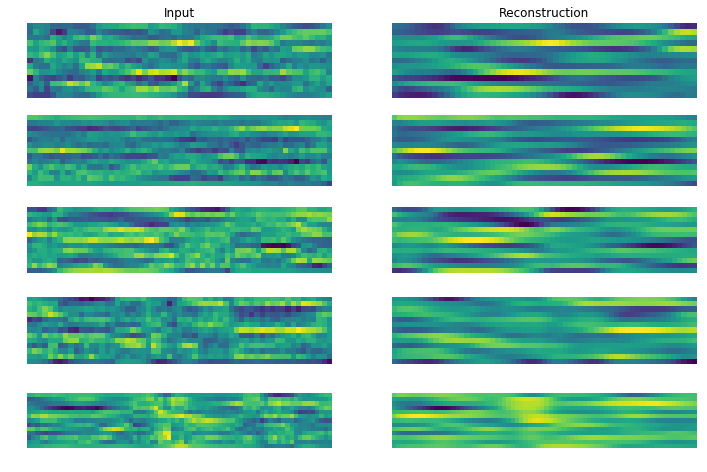

In [87]:
# Plot reconstruction
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    if i == 0:
        plt.title("Input")
    plt.imshow(np_x[i][:np_x_lengths[i]].T)
    plt.axis("off")
    plt.subplot(5, 2, 2*i + 2)
    if i == 0:
        plt.title("Reconstruction")
    plt.imshow(np_y[i][:np_x_lengths[i]].T)
    plt.axis("off")

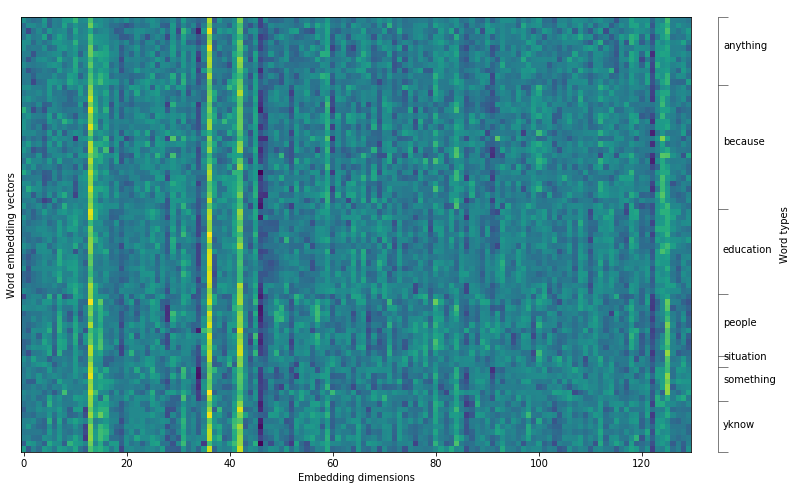

In [88]:
plotting.plot_raw_embeds(
    embed_dict, ["because", "yknow", "people", "something", "anything", "education", "situation"],
    figsize=(12, 8)
    )

## Autoencoder with latent transformation and Bernoulli log-loss

In [68]:
tf.reset_default_graph()

# Training parameters
learning_rate = 0.001
n_epochs = 400  # 50
batch_size = 100
n_buckets = 3

# Model parameters
n_input = d_frame
n_hidden = 150
build_latent_func = tflego.build_autoencoder
latent_func_kwargs = {
    "enc_n_hiddens": [],
    "n_z": 130,
    "dec_n_hiddens": [n_hidden],
    "activation": tf.nn.relu
    }
rnn_type = "gru"  # "lstm", "gru" or "rnn"
model_fn = path.join(output_dir, "lazydynamic_latent_ae.ckpt")

# Model
x = tf.placeholder(TF_DTYPE, [None, None, n_input])
x_lengths = tf.placeholder(TF_ITYPE, [None])
network_dict = tflego.build_encdec_lazydynamic_latentfunc(
    x, x_lengths, n_hidden, build_latent_func,
    latent_func_kwargs, rnn_type=rnn_type
    )
encoder_states = network_dict["encoder_states"]
y = network_dict["decoder_output"]
ae = network_dict["latent_layer"]
mask = network_dict["mask"]
z = ae["z"]

y = tf.nn.sigmoid(y)
y *= tf.expand_dims(mask, -1)  # safety

# Reconstruction loss
log_loss = x*tf.log(1e-10 + y) + (1 - x)*tf.log(1e-10 + 1 - y)
reconstruction_loss = -tf.reduce_sum(log_loss, -1)
reconstruction_loss *= mask  # safety
reconstruction_loss = tf.reduce_sum(reconstruction_loss, -1) / tf.reduce_sum(mask, 1)
reconstruction_loss = tf.reduce_mean(reconstruction_loss) # https://danijar.com/variable-sequence-lengths-in-tensorflow/
loss = reconstruction_loss
# loss = tf.reduce_mean(
#     tf.reduce_sum(tf.reduce_mean(tf.square(x - y), -1), -1) /
#     tf.reduce_sum(mask, 1)
#     )  # https://danijar.com/variable-sequence-lengths-in-tensorflow/

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

In [69]:
np.random.seed(1)
train_batch_iterator = SimpleBucketIterator(
    train_x_scaled, batch_size, n_buckets, True
    )
val_batch_iterator = SimpleBucketIterator(
    val_x_scaled, batch_size, n_buckets, False
    )

record_dict = training.train_fixed_epochs(
    n_epochs, optimizer, loss, train_batch_iterator,
    [x, x_lengths], loss, val_batch_iterator, save_best_val_model_fn=model_fn
    )


2018-08-08 10:36:36.989586
Epoch 0:
3.391 sec, train loss: 9.0733, val loss: 8.98056 *
Epoch 1:
3.332 sec, train loss: 8.97566, val loss: 8.96931 *
Epoch 2:
3.340 sec, train loss: 8.96457, val loss: 8.96166 *
Epoch 3:
3.341 sec, train loss: 8.95874, val loss: 8.95886 *
Epoch 4:
3.330 sec, train loss: 8.95299, val loss: 8.95234 *
Epoch 5:
3.334 sec, train loss: 8.94924, val loss: 8.94943 *
Epoch 6:
3.334 sec, train loss: 8.94623, val loss: 8.94729 *
Epoch 7:
3.338 sec, train loss: 8.94247, val loss: 8.94452 *
Epoch 8:
3.341 sec, train loss: 8.94079, val loss: 8.94551
Epoch 9:
3.331 sec, train loss: 8.9376, val loss: 8.93949 *
Epoch 10:
3.339 sec, train loss: 8.93466, val loss: 8.93734 *
Epoch 11:
3.346 sec, train loss: 8.93197, val loss: 8.938
Epoch 12:
3.329 sec, train loss: 8.93078, val loss: 8.93532 *
Epoch 13:
3.337 sec, train loss: 8.92943, val loss: 8.93541
Epoch 14:
3.319 sec, train loss: 8.92843, val loss: 8.93376 *
Epoch 15:
3.331 sec, train loss: 8.92684, val loss: 8.93217 *
E

Epoch 134:
3.336 sec, train loss: 8.8427, val loss: 8.85325
Epoch 135:
3.325 sec, train loss: 8.84308, val loss: 8.85068 *
Epoch 136:
3.336 sec, train loss: 8.84143, val loss: 8.85128
Epoch 137:
3.334 sec, train loss: 8.84192, val loss: 8.8515
Epoch 138:
3.335 sec, train loss: 8.84226, val loss: 8.85053 *
Epoch 139:
3.337 sec, train loss: 8.84136, val loss: 8.85029 *
Epoch 140:
3.339 sec, train loss: 8.84132, val loss: 8.85317
Epoch 141:
3.327 sec, train loss: 8.8421, val loss: 8.85213
Epoch 142:
3.331 sec, train loss: 8.84114, val loss: 8.85205
Epoch 143:
3.338 sec, train loss: 8.84094, val loss: 8.85048
Epoch 144:
3.334 sec, train loss: 8.8403, val loss: 8.84912 *
Epoch 145:
3.341 sec, train loss: 8.83941, val loss: 8.84902 *
Epoch 146:
3.334 sec, train loss: 8.84064, val loss: 8.85143
Epoch 147:
3.326 sec, train loss: 8.84002, val loss: 8.84991
Epoch 148:
3.328 sec, train loss: 8.84012, val loss: 8.84882 *
Epoch 149:
3.340 sec, train loss: 8.83907, val loss: 8.84782 *
Epoch 150:
3.3

Epoch 268:
3.337 sec, train loss: 8.82551, val loss: 8.83552
Epoch 269:
3.327 sec, train loss: 8.82515, val loss: 8.83337 *
Epoch 270:
3.334 sec, train loss: 8.82492, val loss: 8.83406
Epoch 271:
3.331 sec, train loss: 8.82495, val loss: 8.83502
Epoch 272:
3.328 sec, train loss: 8.82467, val loss: 8.83299 *
Epoch 273:
3.346 sec, train loss: 8.82421, val loss: 8.83297 *
Epoch 274:
3.329 sec, train loss: 8.82403, val loss: 8.83361
Epoch 275:
3.325 sec, train loss: 8.82505, val loss: 8.83365
Epoch 276:
3.332 sec, train loss: 8.82435, val loss: 8.83404
Epoch 277:
3.320 sec, train loss: 8.82635, val loss: 8.8342
Epoch 278:
3.329 sec, train loss: 8.8246, val loss: 8.83291 *
Epoch 279:
3.326 sec, train loss: 8.82388, val loss: 8.83283 *
Epoch 280:
3.341 sec, train loss: 8.82407, val loss: 8.83271 *
Epoch 281:
3.342 sec, train loss: 8.82367, val loss: 8.83371
Epoch 282:
3.325 sec, train loss: 8.82534, val loss: 8.83619
Epoch 283:
3.325 sec, train loss: 8.82496, val loss: 8.83292
Epoch 284:
3.3

In [70]:
# Embed validation
val_batch_iterator = SimpleIterator(
    val_x_scaled, len(val_x), False
    )
labels = [val_labels[i] for i in val_batch_iterator.indices]
saver = tf.train.Saver()
with tf.Session() as session:
    saver.restore(session, model_fn)
    for batch_x_padded, batch_x_lengths in val_batch_iterator:
        np_x = batch_x_padded
        np_x_lengths = batch_x_lengths
        np_z = session.run(
            [z], feed_dict={x: np_x, x_lengths: np_x_lengths}
            )[0]
        np_y = session.run(
            [y], feed_dict={x: np_x, x_lengths: np_x_lengths}
            )[0]
        break  # single batch

embed_dict = {}
for i, utt_key in enumerate([val_keys[i] for i in val_batch_iterator.indices]):
    embed_dict[utt_key] = np_z[i]

INFO:tensorflow:Restoring parameters from /tmp/data-kamperh/lazydynamic_latent_ae.ckpt


In [72]:
# Same-different evaluation
distances = pdist(np_z, metric="cosine")
matches = samediff.generate_matches_array(labels)
ap, prb = samediff.average_precision(
    distances[matches == True], distances[matches == False]
    )

print("Average precision: {:.4f}".format(ap))
print("Precision-recall breakeven: {:.4f}".format(prb))

Average precision: 0.1810
Precision-recall breakeven: 0.2285


In [77]:
# Same-different evaluation after normalisation
np_z_normalised = (np_z - np_z.mean(axis=0))/np_z.std(axis=0)
distances = pdist(np_z_normalised, metric="cosine")
matches = samediff.generate_matches_array(labels)
ap, prb = samediff.average_precision(
    distances[matches == True], distances[matches == False]
    )

print("Average precision: {:.4f}".format(ap))
print("Precision-recall breakeven: {:.4f}".format(prb))

Average precision: 0.1863
Precision-recall breakeven: 0.2322


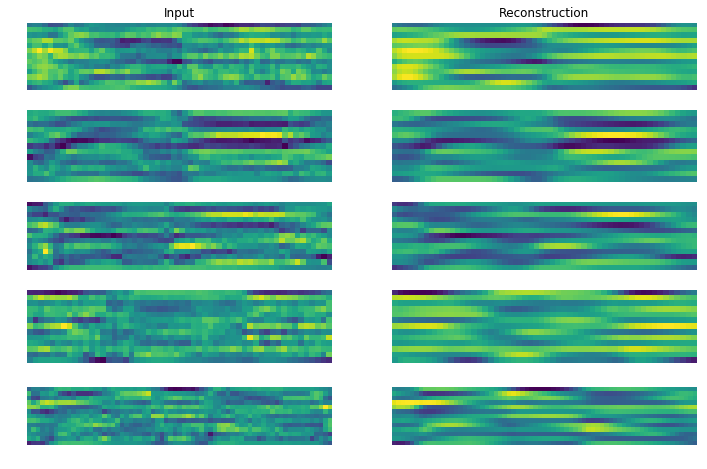

In [73]:
# Plot reconstruction
plt.figure(figsize=(12, 8))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    if i == 0:
        plt.title("Input")
    plt.imshow(np_x[i][:np_x_lengths[i]].T)
    plt.axis("off")
    plt.subplot(5, 2, 2*i + 2)
    if i == 0:
        plt.title("Reconstruction")
    plt.imshow(np_y[i][:np_x_lengths[i]].T)
    plt.axis("off")

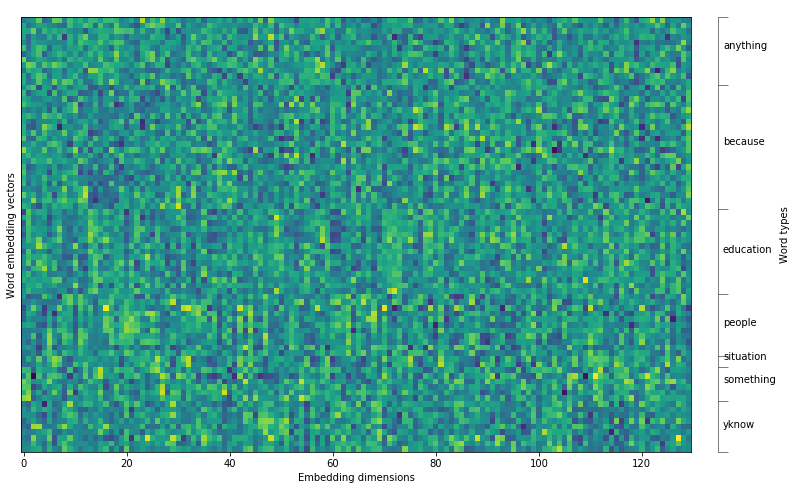

In [75]:
plotting.plot_raw_embeds(
    embed_dict, ["because", "yknow", "people", "something", "anything", "education", "situation"],
    mvn=True, figsize=(12, 8)
    )